### Modelos

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Cargar los datos
df = pd.read_excel("Base_Limpia.xlsx")

# Convertir las columnas categóricas a dummies
columnas_a_convertir = [
    'estu_tipodocumento', 'cole_area_ubicacion', 'cole_bilingue',
    'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_jornada',
    'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_nombre_establecimiento',
    'cole_nombre_sede', 'cole_sede_principal', 'estu_depto_presentacion',
    'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_genero',
    'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad',
    'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar',
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda',
    'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador',
    'fami_tieneinternet', 'fami_tienelavadora', 'desemp_ingles'
]

df_dummies = pd.get_dummies(df[columnas_a_convertir], drop_first=True)

# Combinar las columnas originales con las dummies
df_final = pd.concat([df.drop(columns=columnas_a_convertir), df_dummies], axis=1)

# Filtrar filas válidas en 'punt_global' y fechas válidas
df_caldas = df_final[df_final['punt_global'].notna()]
df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]

/var/folders/3k/yvqxg5fs60x9q4t5nyz08bvc0000gn/T/ipykernel_2377/1340890804.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]


#### Iteración en MLflow

In [27]:
# Configuración de hiperparámetros
num_capas = [2, 3, 4]  # Diferentes números de capas
neuronas_por_capa = [32, 64, 128]  # Diferentes tamaños de capa
dropout_rates = [0.2, 0.3, 0.4]  # Tasas de dropout
configuraciones = list(product(num_capas, neuronas_por_capa, dropout_rates))

print(f"Total de configuraciones: {len(configuraciones)}")


Total de configuraciones: 27


In [33]:
with mlflow.start_run(nested=True):
    # Registrar parámetros, métricas, y modelos aquí
    mlflow.log_param("param1", 42)
    mlflow.log_metric("accuracy", 0.95)

🏃 View run ambitious-smelt-63 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/dd6854e7e1344dd491cc0e0bd2b9a7b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
import numpy as np

def crear_modelo(num_capas, num_neuronas, dropout_rate, input_dim, tipo_modelo):
    model = Sequential()
    for _ in range(num_capas):
        model.add(Dense(num_neuronas, activation='relu', input_dim=input_dim))
        model.add(Dropout(dropout_rate))
    if tipo_modelo == "clasificación":
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    elif tipo_modelo == "regresión":
        model.add(Dense(1, activation='linear'))
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def entrenar_modelo(config, tipo_modelo, X_train, y_train, X_test, y_test, epochs=30):
    num_capas, num_neuronas, dropout_rate = config

    # Verificar y cerrar ejecuciones activas
    if mlflow.active_run() is not None:
        mlflow.end_run()

    # Configurar el experimento en MLflow
    mlflow.set_experiment(f"Modelos {tipo_modelo}")

    with mlflow.start_run():
        try:
            # Crear el modelo
            model = crear_modelo(num_capas, num_neuronas, dropout_rate, X_train.shape[1], tipo_modelo)

            # Entrenar el modelo
            model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=0)

            # Evaluar el modelo
            y_pred = model.predict(X_test).flatten()
            y_pred = np.nan_to_num(y_pred)  # Manejo de valores NaN o infinitos

            if tipo_modelo == "clasificación":
                y_pred_binary = (y_pred > 0.5).astype(int)

                # Calcular métricas de clasificación
                accuracy = accuracy_score(y_test, y_pred_binary)
                precision = precision_score(y_test, y_pred_binary)
                recall = recall_score(y_test, y_pred_binary)
                f1 = f1_score(y_test, y_pred_binary)
                roc_auc = roc_auc_score(y_test, y_pred)

                # Registrar métricas en MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1_score", f1)
                mlflow.log_metric("roc_auc", roc_auc)

                # Imprimir todas las métricas
                print(f"Config: {config} -> Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}, ROC AUC: {roc_auc:.2f}, Recall: {recall:.2f}")

            elif tipo_modelo == "regresión":
                # Calcular métricas de regresión
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)

                # Registrar métricas en MLflow
                mlflow.log_metric("mse", mse)
                mlflow.log_metric("rmse", rmse)

                # Imprimir métricas de regresión
                print(f"Config: {config} -> MSE: {mse:.2f}, RMSE: {rmse:.2f}")

            # Registrar hiperparámetros y el modelo
            mlflow.log_param("num_capas", num_capas)
            mlflow.log_param("num_neuronas", num_neuronas)
            mlflow.log_param("dropout_rate", dropout_rate)
            mlflow.keras.log_model(model, f"{tipo_modelo}_model")
        except Exception as e:
            print(f"Error durante la ejecución: {e}")
        finally:
            mlflow.end_run()

In [38]:
# Iterar sobre configuraciones para clasificación
for config in configuraciones:
    entrenar_modelo(config, "clasificación", X_train, y_train_class, X_test, y_test_class)

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


2024/11/28 10:50:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.2) -> Accuracy: 0.89, F1 Score: 0.58, ROC AUC: 0.92, Recall: 0.44


2024/11/28 10:50:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run resilient-fowl-290 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/0a0de309fff64fee9170ce5d92b3b652
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


2024/11/28 10:51:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.3) -> Accuracy: 0.89, F1 Score: 0.61, ROC AUC: 0.92, Recall: 0.50


2024/11/28 10:51:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run resilient-bee-126 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/c6553c7f36804f5a9ea403cdf03036ac
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


2024/11/28 10:51:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.4) -> Accuracy: 0.89, F1 Score: 0.61, ROC AUC: 0.92, Recall: 0.50


2024/11/28 10:51:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run gregarious-stag-627 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/7f1e7bcc2b764b4190acbbe8ec47d7ad
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step


2024/11/28 10:51:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 64, 0.2) -> Accuracy: 0.89, F1 Score: 0.62, ROC AUC: 0.92, Recall: 0.51


2024/11/28 10:52:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run loud-sponge-959 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/9a23ed18169543abb707b367215f1fbc
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


2024/11/28 10:52:30 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 64, 0.3) -> Accuracy: 0.89, F1 Score: 0.62, ROC AUC: 0.92, Recall: 0.51


2024/11/28 10:52:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run gifted-squirrel-518 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/7e192fd00e974870a195bde9ea9f058c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


2024/11/28 10:53:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 64, 0.4) -> Accuracy: 0.89, F1 Score: 0.60, ROC AUC: 0.92, Recall: 0.48


2024/11/28 10:53:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run skittish-calf-541 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/1048393c7bc44dc58bf02e36a3dc0ff8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step
Config: (2, 128, 0.2) -> Accuracy: 0.89, F1 Score: 0.63, ROC AUC: 0.92, Recall: 0.55


2024/11/28 10:53:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 10:53:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run sedate-penguin-850 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/11beb1c0807744cbac36986bea631b8c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


2024/11/28 10:54:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 128, 0.3) -> Accuracy: 0.89, F1 Score: 0.57, ROC AUC: 0.92, Recall: 0.43


2024/11/28 10:54:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run indecisive-frog-401 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/58f91fdd52dd4726824bf8773bcfaafe
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Config: (2, 128, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 10:54:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 10:54:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run sneaky-swan-63 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/960c2fbd57dc484b8dc4ba2c08c43542
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


2024/11/28 10:55:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 32, 0.2) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 10:55:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run resilient-stag-532 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/ba71350a73da43e9ab99e636c59f4e9d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


2024/11/28 10:55:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 32, 0.3) -> Accuracy: 0.89, F1 Score: 0.57, ROC AUC: 0.92, Recall: 0.43


2024/11/28 10:55:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run unique-mole-133 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/20b4a9a4855d44b588f40c6ac20b8bfd
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


2024/11/28 10:56:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 32, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 10:56:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run upset-jay-380 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/0409b2453d0b4c86a1ca29b8267d01e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


2024/11/28 10:56:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 64, 0.2) -> Accuracy: 0.89, F1 Score: 0.61, ROC AUC: 0.92, Recall: 0.50


2024/11/28 10:56:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run valuable-dog-569 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/62a56dee81fd4817b9eb2199465b5a5f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step
Config: (3, 64, 0.3) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 10:57:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 10:57:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run auspicious-fly-621 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/d86492e3514143afa16e1a3ba726702b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 290us/step


2024/11/28 10:57:51 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 64, 0.4) -> Accuracy: 0.88, F1 Score: 0.57, ROC AUC: 0.92, Recall: 0.45


2024/11/28 10:57:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run shivering-deer-932 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/db86584e97484b49bbb3cd9fe3b6f462
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


2024/11/28 10:58:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 128, 0.2) -> Accuracy: 0.89, F1 Score: 0.62, ROC AUC: 0.92, Recall: 0.54


2024/11/28 10:58:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run exultant-smelt-16 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/91ad28faac1e47539d5416bc588377e6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


2024/11/28 11:19:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 128, 0.3) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:19:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run defiant-asp-321 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/53e1662ebc314aa098d06db6674a54cb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


2024/11/28 11:20:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 128, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:20:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run honorable-vole-720 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/3bf09c41e740465b9e8122e8c218014b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
Config: (4, 32, 0.2) -> Accuracy: 0.89, F1 Score: 0.57, ROC AUC: 0.92, Recall: 0.43


2024/11/28 11:20:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 11:20:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run stately-turtle-513 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/76a8cbaa179b49a6a47d6d096f94b80c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


2024/11/28 11:21:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 32, 0.3) -> Accuracy: 0.89, F1 Score: 0.57, ROC AUC: 0.92, Recall: 0.43


2024/11/28 11:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run illustrious-grub-360 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/870cb5dd4a414adba3dfdb7178b4d15d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 308us/step


2024/11/28 11:21:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 32, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:22:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run wise-mule-297 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/1bac4b3816e245708b2e318b9a6a1c47
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


2024/11/28 11:22:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 64, 0.2) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:22:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run treasured-donkey-403 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/d9c767663ce74f11b171e4ac64d84325
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step
Config: (4, 64, 0.3) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:26:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 11:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run calm-crab-91 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/4f380f7e589d48cf987074af355e6e6b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
Config: (4, 64, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:27:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 11:27:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run gifted-midge-758 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/f336b89b84294255b04fc8b1de567708
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


2024/11/28 11:28:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 128, 0.2) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:28:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run stately-boar-679 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/2358c83457bd489482602a9748d5ea5f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
Config: (4, 128, 0.3) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:28:55 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 11:28:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run victorious-fowl-164 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/04b300d37cce42c9b90d1dfa8d56550d
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


2024/11/28 11:29:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 128, 0.4) -> Accuracy: 0.89, F1 Score: 0.56, ROC AUC: 0.92, Recall: 0.42


2024/11/28 11:29:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run abrasive-vole-940 at: http://127.0.0.1:5000/#/experiments/182041493394083450/runs/fdc78132a0f048089a31053ee6e89f38
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/182041493394083450


In [39]:
# Iterar sobre configuraciones para regresión
for config in configuraciones:
    entrenar_modelo(config, "regresión", X_train, y_train_reg, X_test, y_test_reg)


/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


2024/11/28 14:26:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.2) -> MSE: 1068.75, RMSE: 32.69


2024/11/28 14:26:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run overjoyed-rook-756 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/e86023c3de074f9ca00db81c5df3ca5c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


2024/11/28 14:27:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.3) -> MSE: 1089.99, RMSE: 33.01


2024/11/28 14:27:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run zealous-carp-698 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/bcce4a4ba3994236ab5d5b6f3483fc15
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


2024/11/28 14:27:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 32, 0.4) -> MSE: 1131.61, RMSE: 33.64


2024/11/28 14:27:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run youthful-jay-806 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/c823e9b963f2442b947c785a3b10735b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
Config: (2, 64, 0.2) -> MSE: 1092.08, RMSE: 33.05


2024/11/28 14:28:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:28:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run auspicious-kite-409 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/a86944da20e94195b832961c3ba77f54
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step


2024/11/28 14:28:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 64, 0.3) -> MSE: 1101.56, RMSE: 33.19


2024/11/28 14:28:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run bold-squid-999 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/b1fe87e7029d4e44819d6afc94091a12
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
Config: (2, 64, 0.4) -> MSE: 1068.52, RMSE: 32.69


2024/11/28 14:29:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:29:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run stylish-crow-919 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/e6de478cede842f6bcdd9c53db75376e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


2024/11/28 14:29:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 128, 0.2) -> MSE: 1059.54, RMSE: 32.55


2024/11/28 14:29:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run dapper-dolphin-560 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/6c304c8a2aa940ab875a90fb4980f3c0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step
Config: (2, 128, 0.3) -> MSE: 1078.78, RMSE: 32.84


2024/11/28 14:30:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:30:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run luxuriant-pug-151 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/ead1f4da5b064ef4b668385d811e7d6c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


2024/11/28 14:30:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (2, 128, 0.4) -> MSE: 1062.83, RMSE: 32.60


2024/11/28 14:30:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run popular-seal-144 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/d7035c27c1d84d2cbffee03f0c7e494e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step
Config: (3, 32, 0.2) -> MSE: 1076.01, RMSE: 32.80


2024/11/28 14:31:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:31:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run grandiose-chimp-229 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/f9c6bb70e866452a9f6528fa76395f7c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


2024/11/28 14:31:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 32, 0.3) -> MSE: 1098.77, RMSE: 33.15


2024/11/28 14:31:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run marvelous-shrew-731 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/8eb480e49b61486e8b1e0fab168152ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


2024/11/28 14:32:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 32, 0.4) -> MSE: 1182.07, RMSE: 34.38


2024/11/28 14:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run loud-rat-508 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/a65098b1ca2c43a3b62f04d3e82a9d5a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
Config: (3, 64, 0.2) -> MSE: 1053.12, RMSE: 32.45


2024/11/28 14:32:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:32:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run bald-grouse-395 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/8e9ab8f294d84cd6864870acab3e307b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step
Config: (3, 64, 0.3) -> MSE: 1071.61, RMSE: 32.74


2024/11/28 14:33:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:33:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run wise-hare-598 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/d86664247d574290af76a42b5e4b54e7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


2024/11/28 14:33:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 64, 0.4) -> MSE: 1082.94, RMSE: 32.91


2024/11/28 14:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run wise-gull-112 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/86259fdef97a4657816cd98c362ca20a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step


2024/11/28 14:34:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 128, 0.2) -> MSE: 1059.68, RMSE: 32.55


2024/11/28 14:34:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run traveling-roo-41 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/0becb91169fa47d2944f5e08ce16d355
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
Config: (3, 128, 0.3) -> MSE: 1086.30, RMSE: 32.96


2024/11/28 14:35:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run industrious-ape-144 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/8624ce81361a40f1a65d86aba0487885
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


2024/11/28 14:35:57 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (3, 128, 0.4) -> MSE: 1089.49, RMSE: 33.01


2024/11/28 14:36:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run delicate-shrew-412 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/31bdc1b4bbfb48a78fb50868860b9239
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


2024/11/28 14:36:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 32, 0.2) -> MSE: 1068.01, RMSE: 32.68


2024/11/28 14:36:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run nervous-crab-222 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/497c40606c6a4772a7ce0085d1d9e5b9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


2024/11/28 14:36:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 32, 0.3) -> MSE: 1078.39, RMSE: 32.84


2024/11/28 14:37:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run fun-colt-248 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/a6f010828aa7493faa711a4eaed141a0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step


2024/11/28 14:37:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 32, 0.4) -> MSE: 1127.80, RMSE: 33.58


2024/11/28 14:37:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run redolent-shrimp-868 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/f63a923b931f4872a86ecf4db109c209
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step


2024/11/28 14:38:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 64, 0.2) -> MSE: 1060.04, RMSE: 32.56


2024/11/28 14:38:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run chill-hare-137 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/0e68886a274d41749f4f3416d8627772
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step


2024/11/28 14:38:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 64, 0.3) -> MSE: 1078.38, RMSE: 32.84


2024/11/28 14:38:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run chill-loon-962 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/98c657a4ba0245d5aa2a3c36acb3e466
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


2024/11/28 14:39:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 64, 0.4) -> MSE: 1077.68, RMSE: 32.83


2024/11/28 14:39:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run capricious-cow-178 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/78a625053c6944208e9ba7f13ef9af1c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
Config: (4, 128, 0.2) -> MSE: 1057.69, RMSE: 32.52


2024/11/28 14:40:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:40:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run nervous-mare-474 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/976a2c880d6344db8137fa6821b571c1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
Config: (4, 128, 0.3) -> MSE: 1061.64, RMSE: 32.58


2024/11/28 14:40:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/11/28 14:40:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run skittish-bass-698 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/0a79abf1f03345e5b995677e1f2e8367
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step


2024/11/28 14:41:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Config: (4, 128, 0.4) -> MSE: 1093.24, RMSE: 33.06


2024/11/28 14:41:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run salty-foal-709 at: http://127.0.0.1:5000/#/experiments/600831147481878571/runs/9134345766dd45048709a180b26be61c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/600831147481878571


### Modelo de Clasificación

### Oversampling

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Cargar los datos
df = pd.read_excel("Base_Limpia.xlsx")

# Convertir las columnas categóricas a dummies
columnas_a_convertir = [
    'estu_tipodocumento', 'cole_area_ubicacion', 'cole_bilingue',
    'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_jornada',
    'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_nombre_establecimiento',
    'cole_nombre_sede', 'cole_sede_principal', 'estu_depto_presentacion',
    'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_genero',
    'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad',
    'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar',
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda',
    'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador',
    'fami_tieneinternet', 'fami_tienelavadora', 'desemp_ingles'
]

df_dummies = pd.get_dummies(df[columnas_a_convertir], drop_first=True)

# Combinar las columnas originales con las dummies
df_final = pd.concat([df.drop(columns=columnas_a_convertir), df_dummies], axis=1)

# Filtrar filas válidas en 'punt_global' y fechas válidas
df_caldas = df_final[df_final['punt_global'].notna()]
df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]

# Calcular la edad
df_caldas['edad'] = 2024 - pd.to_datetime(df_caldas['estu_fechanacimiento']).dt.year

# Seleccionar columnas para el modelo
selected_columns_updated = [
    'edad', 'fami_tieneinternet_Si', 'fami_tienecomputador_Si',
    'fami_tieneautomovil_Si', 'fami_tienelavadora_Si',
    'fami_personashogar_Tres', 'fami_personashogar_Una',
    'desemp_ingles_A1', 'desemp_ingles_A2', 'desemp_ingles_B+', 'desemp_ingles_B1',
    'cole_area_ubicacion_URBANO', 'cole_caracter_TÉCNICO', 'cole_caracter_NO APLICA'
]

# Filtrar NaN en las columnas seleccionadas
df_caldas = df_caldas.dropna(subset=selected_columns_updated)

# Preparar variables predictoras y objetivo
X = df_caldas[selected_columns_updated]
y = (df_caldas['punt_global'] >= 300).astype(int)  # Clasificación binaria

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Sobremuestreo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Construir la red neuronal
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_resampled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Salida binaria
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['AUC'])

# Entrenar el modelo
history = model.fit(X_resampled, y_resampled, epochs=50, batch_size=32, verbose=1)

# Evaluar el modelo
y_pred_probs = model.predict(X_test)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Métricas
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))


/var/folders/3k/yvqxg5fs60x9q4t5nyz08bvc0000gn/T/ipykernel_2377/1111585453.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]
/var/folders/3k/yvqxg5fs60x9q4t5nyz08bvc0000gn/T/ipykernel_2377/1111585453.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_caldas['edad'] = 2024 - pd.to_datetime(df_caldas['estu_fechanacimiento']).dt.year


Epoch 1/50


/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3602/3602 ━━━━━━━━━━━━━━━━━━━━ 2s 368us/step - AUC: 0.8828 - loss: 0.4187
Epoch 2/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - AUC: 0.9118 - loss: 0.3724
Epoch 3/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - AUC: 0.9135 - loss: 0.3692
Epoch 4/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - AUC: 0.9152 - loss: 0.3655
Epoch 5/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - AUC: 0.9146 - loss: 0.3669
Epoch 6/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - AUC: 0.9137 - loss: 0.3691
Epoch 7/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - AUC: 0.9147 - loss: 0.3661
Epoch 8/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - AUC: 0.9151 - loss: 0.3657
Epoch 9/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 362us/step - AUC: 0.9158 - loss: 0.3645
Epoch 10/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 365us/step - AUC: 0.9163 - loss: 0.3636
Epoch 11/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step - AUC: 0.9160 - loss: 0.3640
Epoch 12/50
3602/3602 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - AUC: 0.9168 - l

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step
F1 Score: 0.6628
Recall: 0.8118


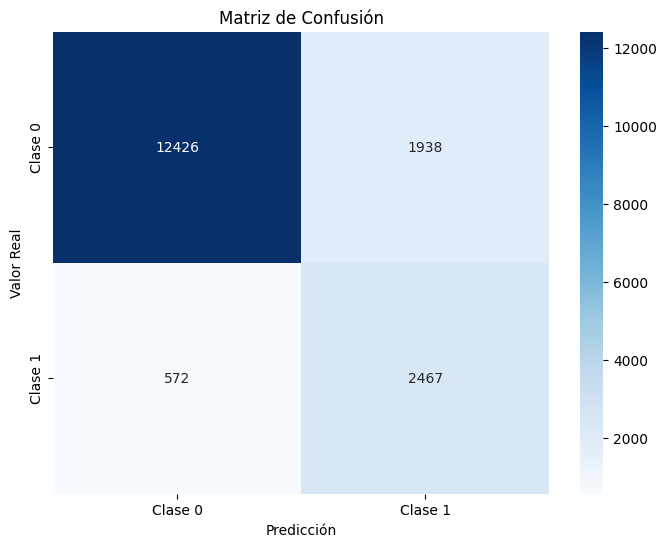

In [7]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convertir probabilidades a clases (0 o 1)

# Calcular F1 Score y Recall
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


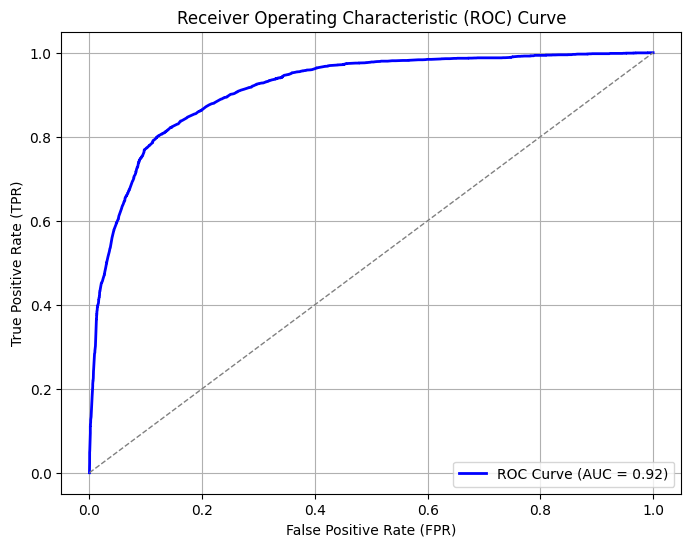

In [9]:
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convertir X_test a tensor si no lo está
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Obtener las probabilidades predichas
y_pred_probs = model.predict(X_test_tensor)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Undersimpling

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Cargar los datos
df = pd.read_excel("Base_Limpia.xlsx")

# Convertir las columnas categóricas a dummies
columnas_a_convertir = [
    'estu_tipodocumento', 'cole_area_ubicacion', 'cole_bilingue',
    'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_jornada',
    'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_nombre_establecimiento',
    'cole_nombre_sede', 'cole_sede_principal', 'estu_depto_presentacion',
    'estu_depto_reside', 'estu_estadoinvestigacion', 'estu_genero',
    'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad',
    'estu_pais_reside', 'estu_privado_libertad', 'fami_cuartoshogar',
    'fami_educacionmadre', 'fami_educacionpadre', 'fami_estratovivienda',
    'fami_personashogar', 'fami_tieneautomovil', 'fami_tienecomputador',
    'fami_tieneinternet', 'fami_tienelavadora', 'desemp_ingles'
]

df_dummies = pd.get_dummies(df[columnas_a_convertir], drop_first=True)

# Combinar las columnas originales con las dummies
df_final = pd.concat([df.drop(columns=columnas_a_convertir), df_dummies], axis=1)

# Filtrar filas válidas en 'punt_global' y fechas válidas
df_caldas = df_final[df_final['punt_global'].notna()]
df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]

# Calcular la edad
df_caldas['edad'] = 2024 - pd.to_datetime(df_caldas['estu_fechanacimiento']).dt.year

# Seleccionar columnas para el modelo
selected_columns_updated = [
    'edad', 'fami_tieneinternet_Si', 'fami_tienecomputador_Si',
    'fami_tieneautomovil_Si', 'fami_tienelavadora_Si',
    'fami_personashogar_Tres', 'fami_personashogar_Una',
    'desemp_ingles_A1', 'desemp_ingles_A2', 'desemp_ingles_B+', 'desemp_ingles_B1',
    'cole_area_ubicacion_URBANO', 'cole_caracter_TÉCNICO', 'cole_caracter_NO APLICA'
]

# Filtrar NaN en las columnas seleccionadas
df_caldas = df_caldas.dropna(subset=selected_columns_updated)

# Preparar variables predictoras y objetivo
X = df_caldas[selected_columns_updated]
y = (df_caldas['punt_global'] >= 300).astype(int)  # Clasificación binaria

import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Realizar undersampling
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# Convertir a numpy.ndarray con tipos compatibles
X_resampled = np.array(X_resampled, dtype=np.float32)
y_resampled = np.array(y_resampled, dtype=np.int32)

# Convertir a tensores
X_resampled_tensor = tf.convert_to_tensor(X_resampled, dtype=tf.float32)
y_resampled_tensor = tf.convert_to_tensor(y_resampled, dtype=tf.float32)

# Verificar que los tensores se han creado correctamente
print("X_resampled_tensor shape:", X_resampled_tensor.shape)
print("y_resampled_tensor shape:", y_resampled_tensor.shape)

# Entrenar el modelo con tensores
model.fit(X_resampled_tensor, y_resampled_tensor, epochs=50, batch_size=32, verbose=1)

# Predecir en los datos de prueba (asegúrate de que X_test esté escalado y sea compatible)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_pred_probs = model.predict(X_test_tensor)
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Métricas
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred_classes))

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_classes))

/var/folders/3k/yvqxg5fs60x9q4t5nyz08bvc0000gn/T/ipykernel_2377/4082396292.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_caldas = df_caldas[pd.to_datetime(df_caldas['estu_fechanacimiento'], errors='coerce').notna()]
/var/folders/3k/yvqxg5fs60x9q4t5nyz08bvc0000gn/T/ipykernel_2377/4082396292.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_caldas['edad'] = 2024 - pd.to_datetime(df_caldas['estu_fechanacimiento']).dt.year


X_resampled_tensor shape: (23976, 14)
y_resampled_tensor shape: (23976,)
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - AUC: 0.9164 - loss: 0.3639
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - AUC: 0.9170 - loss: 0.3620
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - AUC: 0.9167 - loss: 0.3627
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - AUC: 0.9155 - loss: 0.3659
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - AUC: 0.9159 - loss: 0.3647
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - AUC: 0.9176 - loss: 0.3607
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - AUC: 0.9155 - loss: 0.3655
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - AUC: 0.9201 - loss: 0.3561
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - AUC: 0.9141 - loss: 0.3681
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - AUC: 0.9170 - loss: 0.3618
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - AUC: 0.9175 - loss: 0.3610
Epoch 12/50


544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step
F1 Score: 0.6571
Recall: 0.8223


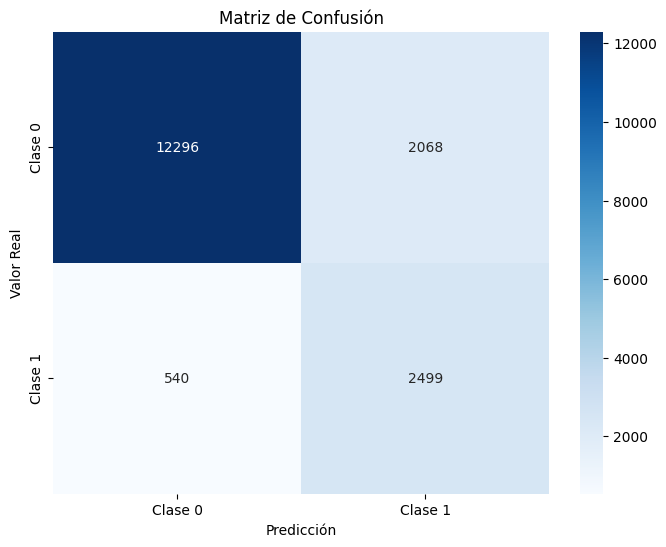

In [11]:
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones
y_pred = (model.predict(X_test) > 0.5).astype(int)  # Convertir probabilidades a clases (0 o 1)

# Calcular F1 Score y Recall
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step


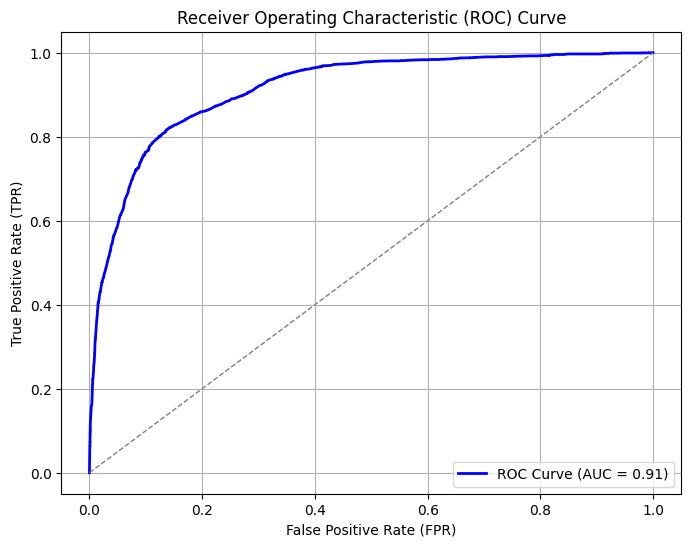

In [12]:
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Convertir X_test a tensor si no lo está
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Obtener las probabilidades predichas
y_pred_probs = model.predict(X_test_tensor)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Sin Sampling

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Variables seleccionadas
categorical_columns = [
    'cole_area_ubicacion', 'cole_caracter', 'cole_bilingue', 'cole_jornada',
    'fami_tienecomputador', 'fami_tieneinternet', 'fami_tienelavadora', 'fami_tieneautomovil'
]

numerical_columns = [
    'edad', 'punt_ingles', 'punt_matematicas', 'punt_sociales_ciudadanas',
    'punt_c_naturales', 'punt_lectura_critica'
]

# Cargar datos
df = pd.read_excel("Base_Limpia.xlsx")

# Corregir las fechas
df['estu_fechanacimiento'] = pd.to_datetime(df['estu_fechanacimiento'], format='%Y-%m-%d', errors='coerce')
df = df[df['estu_fechanacimiento'].notna()]

# Calcular la edad
df['edad'] = 2024 - df['estu_fechanacimiento'].dt.year

# Codificar variables categóricas
encoder = OrdinalEncoder()
df[categorical_columns] = encoder.fit_transform(df[categorical_columns])

# Manejar valores faltantes
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

for col in numerical_columns:
    df[col].fillna(df[col].mean(), inplace=True)

# Normalizar variables numéricas
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Preparar las variables predictoras y objetivo
X = df[categorical_columns + numerical_columns]
y = (df['punt_global'] >= 300).astype(int)  # Clasificación binaria

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar datos de entrada
print(f"X_train contiene NaN: {X_train.isna().any()}")
print(f"Distribución de y_train: {y_train.value_counts(normalize=True)}")

# Configurar el modelo con tasa de aprendizaje reducida
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Salida binaria
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Tasa de aprendizaje reducida
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Calcular pesos de clases para manejar desbalanceo
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)

# Entrenar el modelo
history = model.fit(
    X_train, y_train, 
    epochs=50, batch_size=32, 
    validation_split=0.2, 
    class_weight=class_weights_dict, 
    verbose=1
)

# Evaluar el modelo
y_pred_probs = model.predict(X_test).flatten()
y_pred_classes = (y_pred_probs > 0.5).astype(int)

# Reporte de clasificación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_classes))

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
### Predicción de el modelo de calificación 

### Modelo de regresión

### Oversampling

## Desbalanciada

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np

# Crear el modelo
def build_model():
    model = Sequential()
    # Capa de entrada + primera capa oculta
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(0.2))  # Dropout del 20%
    
    # Segunda capa oculta
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    # Tercera capa oculta
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    
    # Capa de salida (regresión)
    model.add(Dense(1, activation='linear'))  # Salida con activación lineal para regresión
    
    # Compilar el modelo
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Crear el modelo
model = build_model()

# Entrenar el modelo
history = model.fit(
    X_train, y_train, 
    epochs=100,  # Ajusta según sea necesario
    batch_size=32,  # Ajusta según sea necesario
    validation_split=0.2,  # Usar el 20% del entrenamiento como validación
    verbose=1
)

# Evaluar el modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}")

Epoch 1/100


/Users/isabellacastillo/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 560us/step - loss: 0.1052 - mae: 0.2049 - val_loss: 0.0823 - val_mae: 0.1675
Epoch 2/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 550us/step - loss: 0.0828 - mae: 0.1695 - val_loss: 0.0787 - val_mae: 0.1672
Epoch 3/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - loss: 0.0840 - mae: 0.1718 - val_loss: 0.0792 - val_mae: 0.1668
Epoch 4/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 512us/step - loss: 0.0815 - mae: 0.1687 - val_loss: 0.0801 - val_mae: 0.1747
Epoch 5/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 516us/step - loss: 0.0833 - mae: 0.1709 - val_loss: 0.0799 - val_mae: 0.1767
Epoch 6/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.0818 - mae: 0.1687 - val_loss: 0.0804 - val_mae: 0.1732
Epoch 7/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 515us/step - loss: 0.0805 - mae: 0.1663 - val_loss: 0.0791 - val_mae: 0.1659
Epoch 8/100
1741/1741 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - loss: 0.0809 - mae: 0.1662 - val_loss: 0.0785 - val_mae: 0.1601
Epoch 9/100
1741/1741 ━━━━━━